In [ ]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/faces2.rar  /content

In [ ]:
DATASET_PATH ="/content/faces2"
dataset = []
for path in tqdm(glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg"))):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
#too much Bush
dataset.head(10)
imgs = []
for i in tqdm(range(12000)):
  imgs.append(np.asarray(T.Resize(size=100)(Image.open(dataset.path.iloc[i])))/255)


#data = np.array(imgs / 255, dtype='float32')
x_train, x_val = train_test_split(imgs, test_size=0.2, random_state=42)
#X_train = torch.FloatTensor(X_train)
#X_val = torch.FloatTensor(X_val)


train_data = TensorDataset(torch.from_numpy(np.array(x_train)))
valid_data = TensorDataset(torch.from_numpy(np.array(x_val)))
# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

#one random sample
dataiter = iter(train_loader)
sample_x = next(dataiter)

13233it [00:00, 47942.62it/s]
100%|██████████| 12000/12000 [00:25<00:00, 472.05it/s]


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=4232):
        return input.reshape(input.size(0),8, 23, 23)

class Autoencoder_cnn(nn.Module):
    def __init__(self,h_dim=4232, z_dim=50):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten(),

            #nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2,output_padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #print(h.shape)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        x = x.permute(0,3,1,2)
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [ ]:
model = Autoencoder_cnn()
model.to(device)

Autoencoder_cnn(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten()
  )
  (fc1): Linear(in_features=4232, out_features=50, bias=True)
  (fc2): Linear(in_features=4232, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=4232, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (6): Sigmoid()
  )
)

In [ ]:
dataiter = iter(train_loader)
sample_x = next(dataiter)
sample_x = sample_x[0].type(torch.FloatTensor)
i = sample_x.to(device)
i.is_cuda
o = model(i)

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

300it [00:04, 70.84it/s]


Epoch 1, Loss: 544795.7392708333


<ipython-input-31-91ffdcfa4c52>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax2.imshow(torch.tensor(out).squeeze().cpu(),label="test loss")


Epoch 1, Loss: 508940.0283333333


300it [00:03, 78.50it/s]


Epoch 2, Loss: 504960.83166666667
Epoch 2, Loss: 498951.88458333333


300it [00:03, 78.04it/s]


Epoch 3, Loss: 499171.51208333333
Epoch 3, Loss: 495637.2083333333


300it [00:04, 73.07it/s]


Epoch 4, Loss: 497216.87333333335
Epoch 4, Loss: 494766.9320833333


300it [00:03, 77.69it/s]


Epoch 5, Loss: 496101.37145833333
Epoch 5, Loss: 494045.13083333336


300it [00:03, 77.56it/s]


Epoch 6, Loss: 495482.5576041667
Epoch 6, Loss: 493478.31875


300it [00:04, 74.52it/s]


Epoch 7, Loss: 495282.7825
Epoch 7, Loss: 493831.11833333335


300it [00:03, 78.41it/s]


Epoch 8, Loss: 494652.9561458333
Epoch 8, Loss: 493195.15291666664


300it [00:03, 78.21it/s]


Epoch 9, Loss: 494524.53979166667
Epoch 9, Loss: 492914.98041666666


300it [00:04, 74.11it/s]


Epoch 10, Loss: 494287.0057291667
Epoch 10, Loss: 493235.3358333333


300it [00:03, 78.01it/s]


Epoch 11, Loss: 494026.084375
Epoch 11, Loss: 492967.1608333333


300it [00:03, 78.11it/s]


Epoch 12, Loss: 493985.19479166664
Epoch 12, Loss: 492562.49083333334


300it [00:03, 75.38it/s]


Epoch 13, Loss: 493669.01979166665
Epoch 13, Loss: 493442.0266666667


300it [00:03, 76.54it/s]


Epoch 14, Loss: 493744.00604166667
Epoch 14, Loss: 492536.90458333335


300it [00:03, 77.47it/s]


Epoch 15, Loss: 493722.20739583333
Epoch 15, Loss: 492511.85625


300it [00:04, 69.90it/s]


Epoch 16, Loss: 493347.15697916667
Epoch 16, Loss: 493201.6691666667


300it [00:03, 77.28it/s]


Epoch 17, Loss: 493525.17875
Epoch 17, Loss: 492557.2875


300it [00:03, 77.91it/s]


Epoch 18, Loss: 493203.3803125
Epoch 18, Loss: 492537.5758333333


300it [00:03, 75.02it/s]


Epoch 19, Loss: 493308.1617708333
Epoch 19, Loss: 492688.955


300it [00:03, 76.61it/s]


Epoch 20, Loss: 493327.0108333333
Epoch 20, Loss: 493251.4216666667


300it [00:03, 78.45it/s]


Epoch 21, Loss: 493070.84260416665


<ipython-input-31-91ffdcfa4c52>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6, 3))


Epoch 21, Loss: 492438.78125


300it [00:03, 75.63it/s]


Epoch 22, Loss: 493157.88947916665
Epoch 22, Loss: 493389.95


300it [00:03, 75.43it/s]


Epoch 23, Loss: 493125.1377083333
Epoch 23, Loss: 492427.63375


300it [00:03, 78.51it/s]


Epoch 24, Loss: 493014.96145833336
Epoch 24, Loss: 492535.41333333333


300it [00:03, 76.16it/s]


Epoch 25, Loss: 492915.49104166665
Epoch 25, Loss: 492146.08125


300it [00:04, 74.71it/s]


Epoch 26, Loss: 493029.8796875
Epoch 26, Loss: 492880.8283333333


300it [00:03, 78.77it/s]


Epoch 27, Loss: 492710.44177083333
Epoch 27, Loss: 492525.06958333333


300it [00:03, 76.48it/s]


Epoch 28, Loss: 492910.2966666667
Epoch 28, Loss: 492676.6070833333


300it [00:03, 75.38it/s]


Epoch 29, Loss: 492866.85270833335
Epoch 29, Loss: 492336.41041666665


300it [00:03, 77.86it/s]


Epoch 30, Loss: 492588.2551041667
Epoch 30, Loss: 492657.4475


300it [00:03, 76.27it/s]


Epoch 31, Loss: 492671.56177083333
Epoch 31, Loss: 492313.9191666667


300it [00:04, 74.14it/s]


Epoch 32, Loss: 492778.70375
Epoch 32, Loss: 492394.69583333336


300it [00:03, 79.67it/s]


Epoch 33, Loss: 492727.7601041667
Epoch 33, Loss: 493899.30541666667


300it [00:03, 76.85it/s]


Epoch 34, Loss: 492659.639375
Epoch 34, Loss: 493632.48375


300it [00:04, 74.53it/s]


Epoch 35, Loss: 492439.781875
Epoch 35, Loss: 492357.73


300it [00:03, 78.62it/s]


Epoch 36, Loss: 492578.6455208333
Epoch 36, Loss: 492198.96708333335


300it [00:03, 76.38it/s]


Epoch 37, Loss: 492552.93885416666
Epoch 37, Loss: 492088.9920833333


300it [00:03, 75.23it/s]


Epoch 38, Loss: 492449.20739583333
Epoch 38, Loss: 492486.4995833333


300it [00:03, 78.68it/s]


Epoch 39, Loss: 492561.78510416666
Epoch 39, Loss: 492364.6220833333


300it [00:03, 76.64it/s]


Epoch 40, Loss: 492558.71927083336
Epoch 40, Loss: 492253.4345833333


300it [00:04, 74.47it/s]


Epoch 41, Loss: 492372.6584375
Epoch 41, Loss: 493457.325


300it [00:03, 78.82it/s]


Epoch 42, Loss: 492497.98625
Epoch 42, Loss: 492606.9725


300it [00:03, 77.51it/s]


Epoch 43, Loss: 492355.8805208333
Epoch 43, Loss: 492211.92916666664


300it [00:04, 73.44it/s]


Epoch 44, Loss: 492566.4610416667
Epoch 44, Loss: 492228.18083333335


300it [00:03, 77.54it/s]


Epoch 45, Loss: 492294.9892708333
Epoch 45, Loss: 492299.21875


300it [00:03, 76.05it/s]


Epoch 46, Loss: 492271.7459375
Epoch 46, Loss: 492291.3675


300it [00:04, 72.56it/s]


Epoch 47, Loss: 492306.15197916667
Epoch 47, Loss: 492510.70916666667


300it [00:03, 76.97it/s]


Epoch 48, Loss: 492283.12322916667
Epoch 48, Loss: 492264.0595833333


300it [00:03, 75.67it/s]


Epoch 49, Loss: 492267.81072916667
Epoch 49, Loss: 492290.03375


300it [00:04, 73.10it/s]


Epoch 50, Loss: 492272.25927083334
Epoch 50, Loss: 492333.79833333334


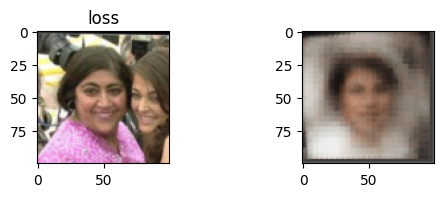

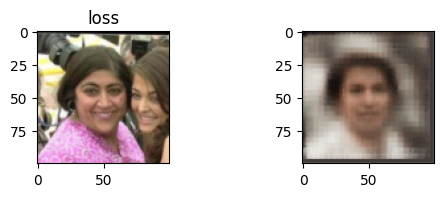

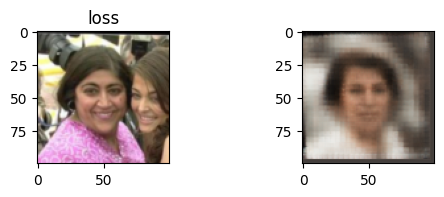

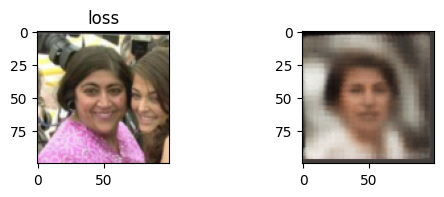

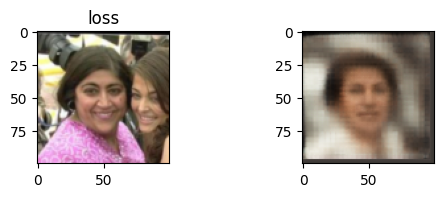

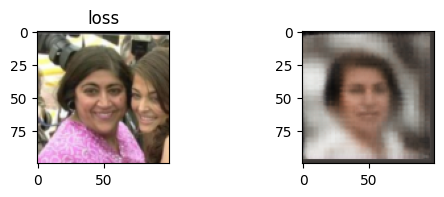

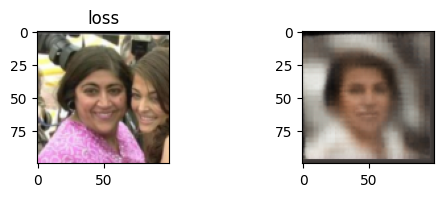

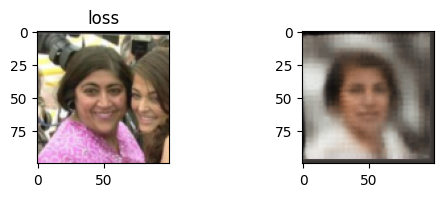

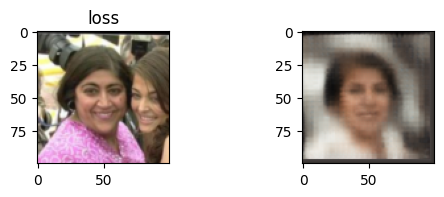

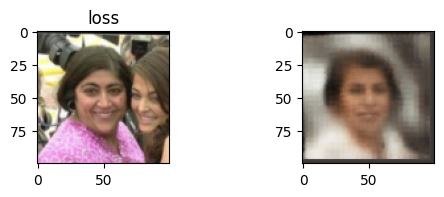

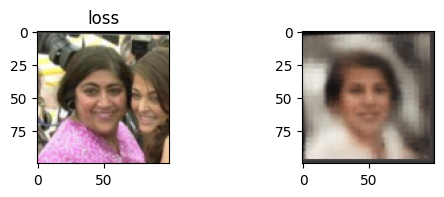

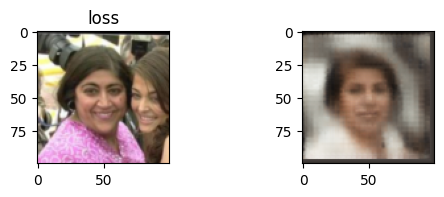

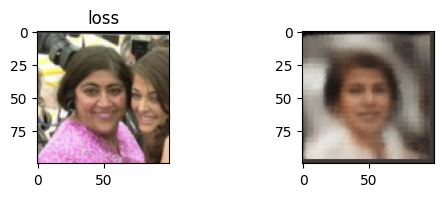

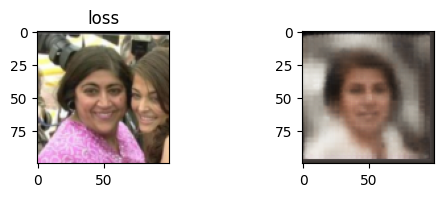

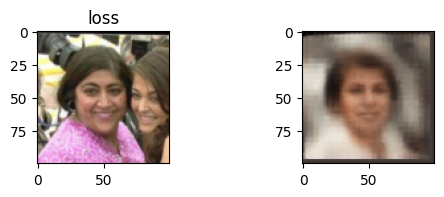

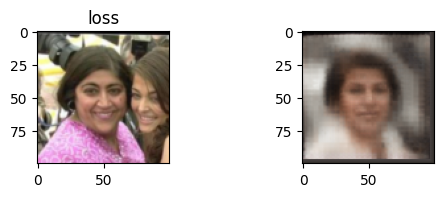

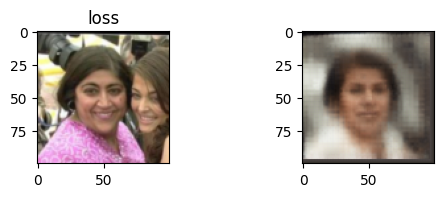

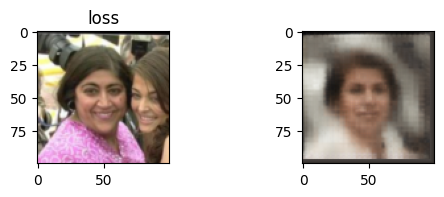

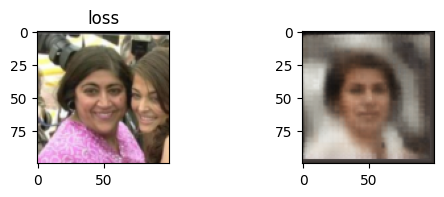

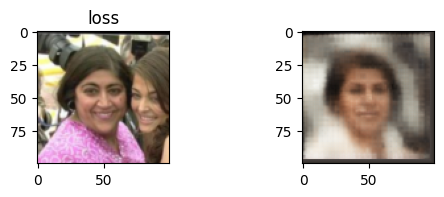

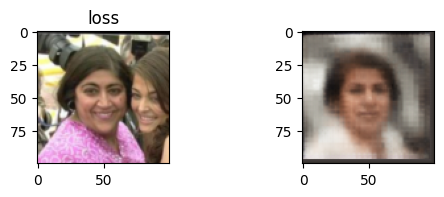

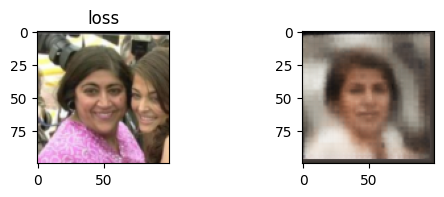

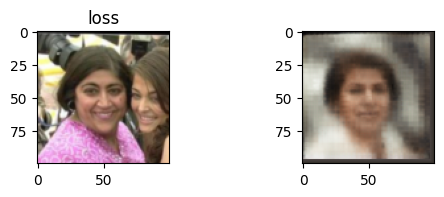

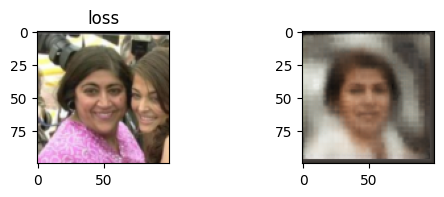

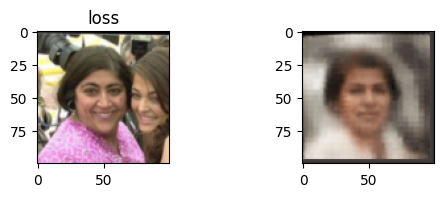

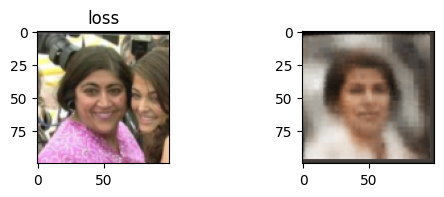

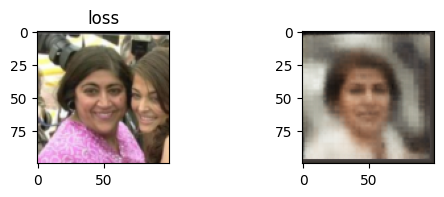

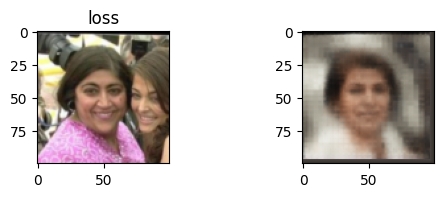

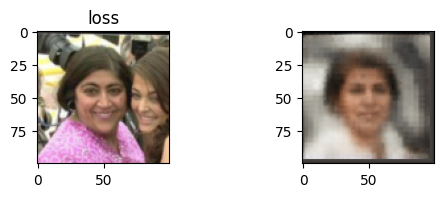

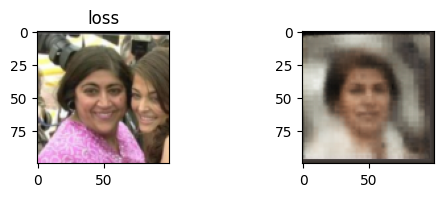

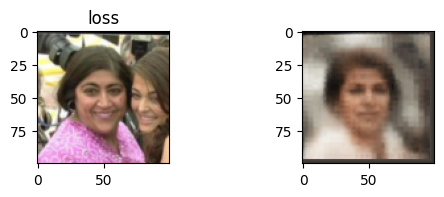

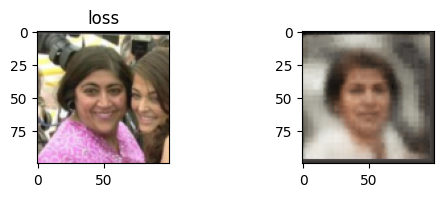

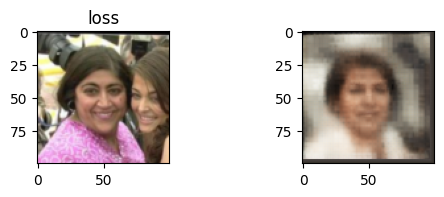

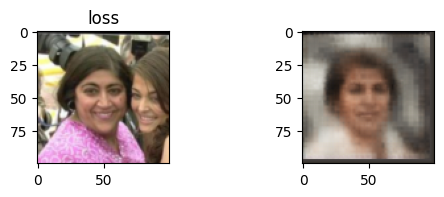

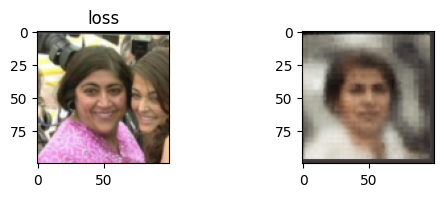

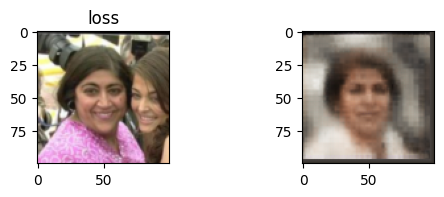

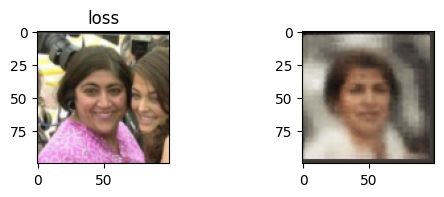

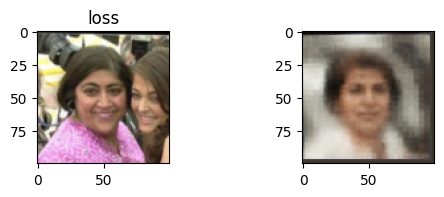

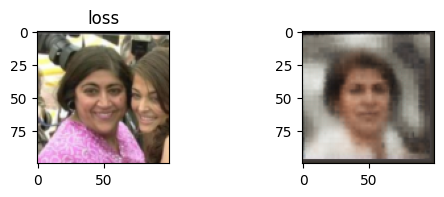

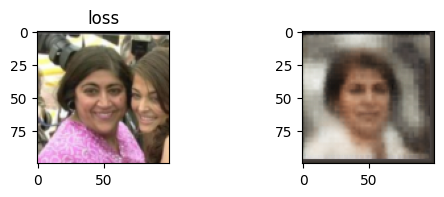

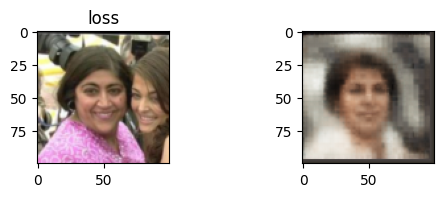

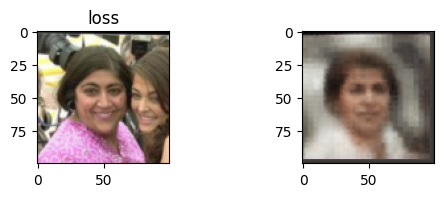

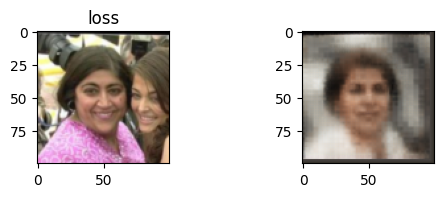

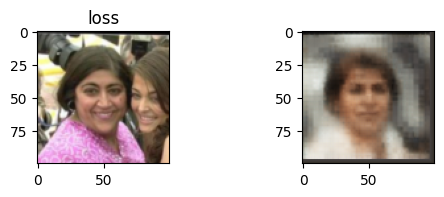

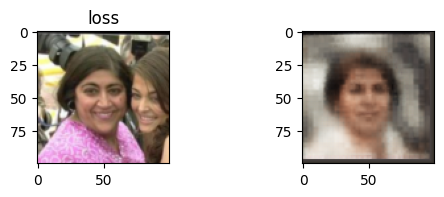

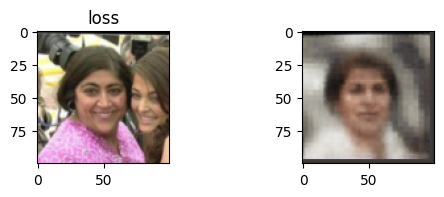

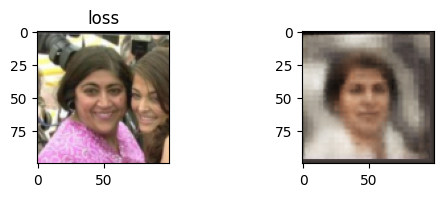

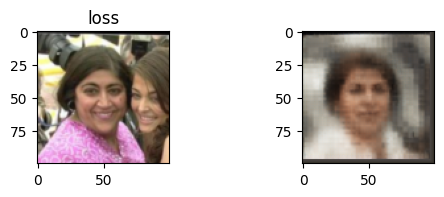

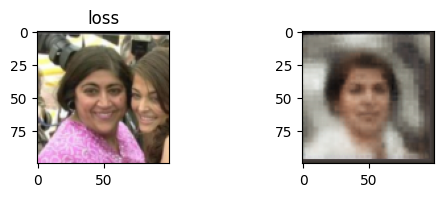

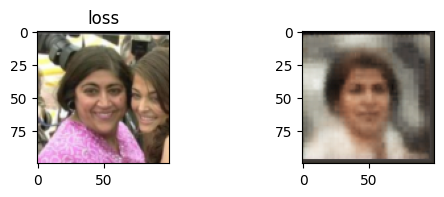

In [ ]:
max_epoch = 50
train_loss = []
test_loss = []
acc = []
# Define the loss function and optimizer
#criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.007, weight_decay=0.001)
# Train the model
for epoch in range(max_epoch):
    a = 0
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs = data[0].type(torch.FloatTensor)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar  = model(inputs)
        #print(outputs.shape)
        recon_images = recon_images.permute(0,2,3,1)
        loss = loss_fn(recon_images, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    train_loss.append(running_loss / len(train_loader))

# Evaluate the model
    test_running_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
          inputs = data[0].type(torch.FloatTensor)
          inputs = inputs.to(device)
          recon_images, mu, logvar  = model(inputs)
          recon_images = recon_images.permute(0,2,3,1)
          loss = loss_fn(recon_images, inputs, mu, logvar)
          test_running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {test_running_loss / len(valid_loader)}")
        test_loss.append(test_running_loss / len(valid_loader))

    pic = torch.FloatTensor(x_val[5])
    recon_images, mu, logvar  = model(pic.unsqueeze(0).to(device))
    out = recon_images.permute(0,2,3,1)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6, 3))
    fig.tight_layout(pad=5.0)
    ax1.imshow(pic, label="train loss")
    ax2.imshow(torch.tensor(out).squeeze().cpu(),label="test loss")
    ax1.set_title("loss")


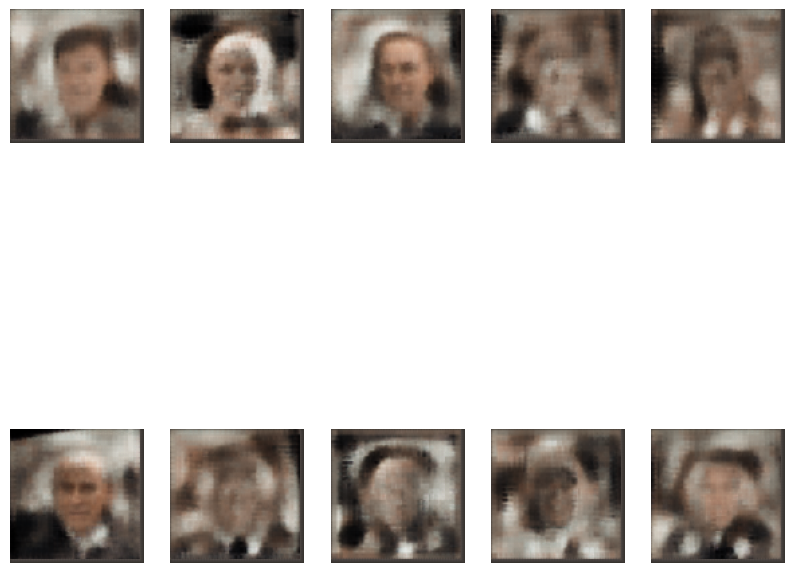

In [ ]:
number_of_images = 10
latent_size = 50
# sample from normal distribution
#latent_space = np.random.normal(mu.detach().cpu(),abs(logvar).detach().cpu(),size=(number_of_images,latent_size))
latent_space = np.random.normal(size=(number_of_images,latent_size))
gen_img = model.decode(torch.FloatTensor(latent_space).to(device))

fig = plt.figure(figsize=(10,10))
for i in range(number_of_images):
    ax = fig.add_subplot(2, int(number_of_images/2), i+1)
    ax.imshow(gen_img[i, :,:,:].permute(1,2,0).detach().cpu())
    ax.axis('off')
plt.show()

In [ ]:
mu.shape

torch.Size([1, 500])